In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from skimage import io
import numpy as np
from scipy.spatial import Delaunay
import networkx as nx
import matplotlib.pyplot as plt
import voronoi
import misc
from misc import show_img
import prop

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Parameters
isHealth = True
minEdgeWidth = 1
maxEdgeWidth = 10

radius = 100   # Distância para conectar glândulas
isGeometricGraph = True

isHealth = True
isMount = True

In [4]:
# Define data paths
root_img_path = 'prostate_marked/S07_46186 10X_20151028_59'
#root_img_path = 'prostate_marked/3'
if not isMount:
    if isHealth:
        img_path = root_img_path + '/'
        img_mask_path = root_img_path + '/'
        result_path = '/'   
    else:
        img_path = root_img_path + '/'
        img_mask_path = root_img_path + '/'
        result_path = '/'
else:
    # Define data paths to 1/4 Mount
    img_path = root_img_path + '/IMG.jpg'
    img_mask_path = root_img_path + '/MASK.jpg'
    img_expert_demarcation_path = root_img_path + '/CA MASK.jpg'
    
    if isGeometricGraph:
        result_path = root_img_path + '/results_radius_' + str(radius)
    else:
        result_path = root_img_path + '/results'

In [5]:
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (137175380 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


<IPython.core.display.Javascript object>


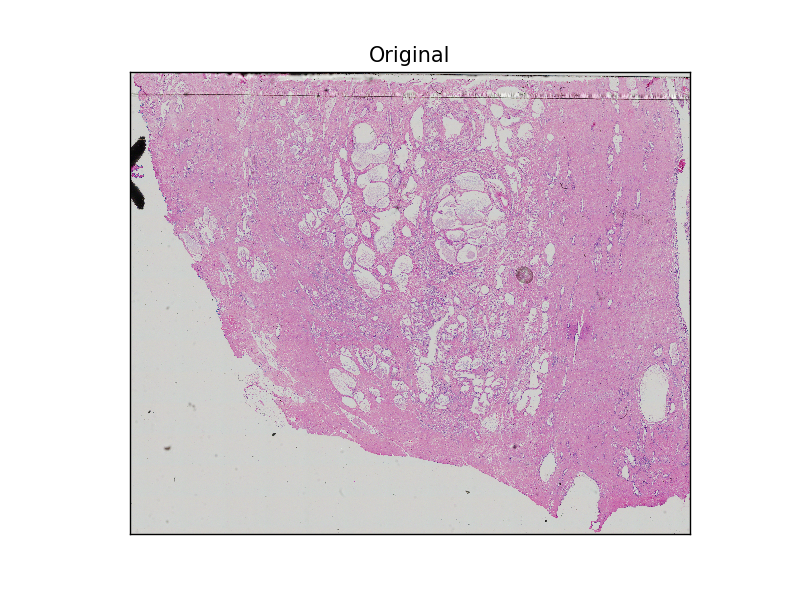

<IPython.core.display.Javascript object>


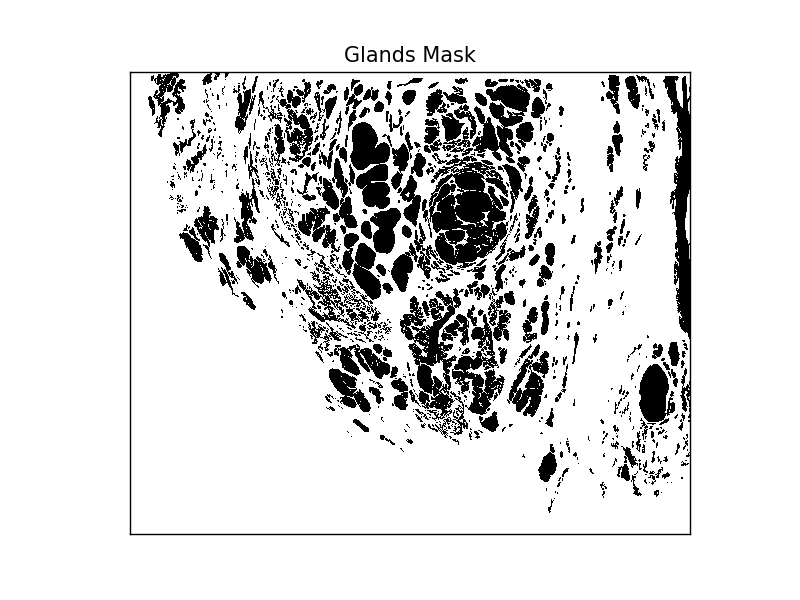

<IPython.core.display.Javascript object>


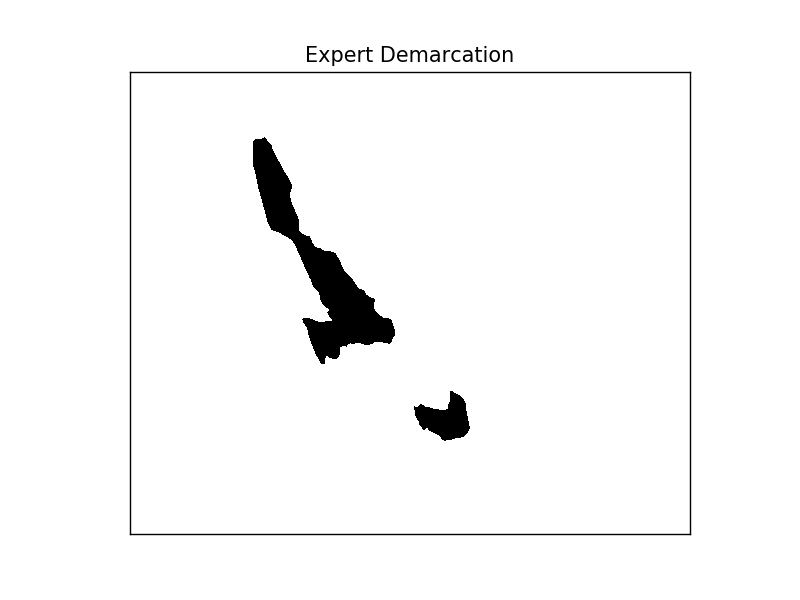

In [6]:
# Read and display images
img = io.imread(img_path)
show_img(img, 'Original')

img_mask = io.imread(img_mask_path)
img_mask = misc.mask_correction(img_mask)
show_img(255-img_mask, 'Glands Mask')
    
if isMount:
    expert_demarcation = io.imread(img_expert_demarcation_path)
    expert_demarcation = misc.mask_correction(expert_demarcation)
    show_img(255-expert_demarcation, 'Expert Demarcation')

In [7]:
import scipy.ndimage as ndi
img_label, n = ndi.label(img_mask)
print(n)

3364


In [8]:
img_expert_label, n_expert = ndi.label(expert_demarcation)
print(n_expert)

2


In [9]:
if not((img.shape[0], img.shape[1]) == img_mask.shape == expert_demarcation.shape):
    print('Images must have the same size')

# Extract Properties from all regions of image mask

In [10]:
shape_props_to_measure = ['area', 'solidity', 'eccentricity', 'equivalent_diameter', 'perimeter']
shape_props, props = prop.get_shape_props_from_mask(img_mask, shape_props_to_measure, return_scikit_props=True)
#prop.display_shape_props(img_mask, shape_props_to_measure, shape_label=42) #36

<IPython.core.display.Javascript object>


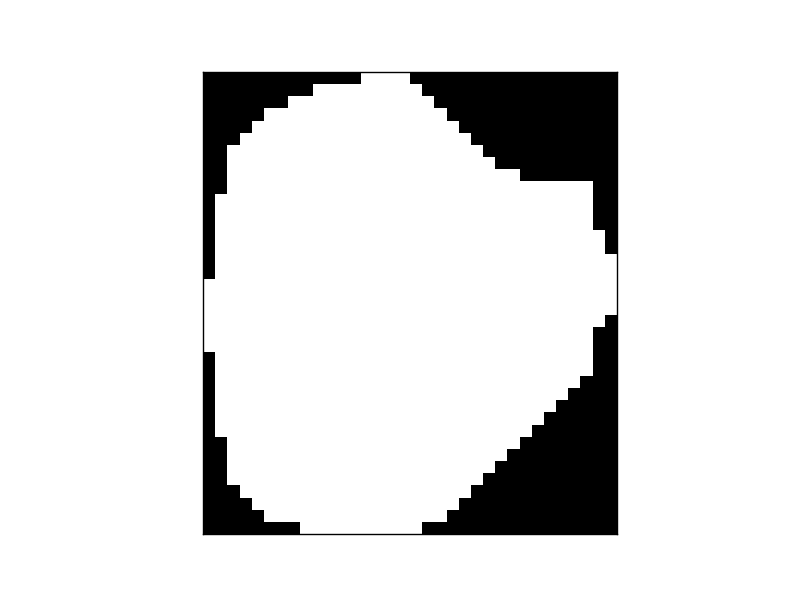

Shape located at [3056, 3884] has properties:
area: 948.00


In [11]:
shape_props_to_measure_area = ['area']
shape_props_area, props_area = prop.get_shape_props_from_mask(img_mask, shape_props_to_measure_area, return_scikit_props=True)
prop.display_shape_props(img_mask, shape_props_to_measure_area, shape_label=1078) #36
#prop.display_shape_props(img_mask, shape_props_to_measure_area, shape_label=3081) #36

<IPython.core.display.Javascript object>


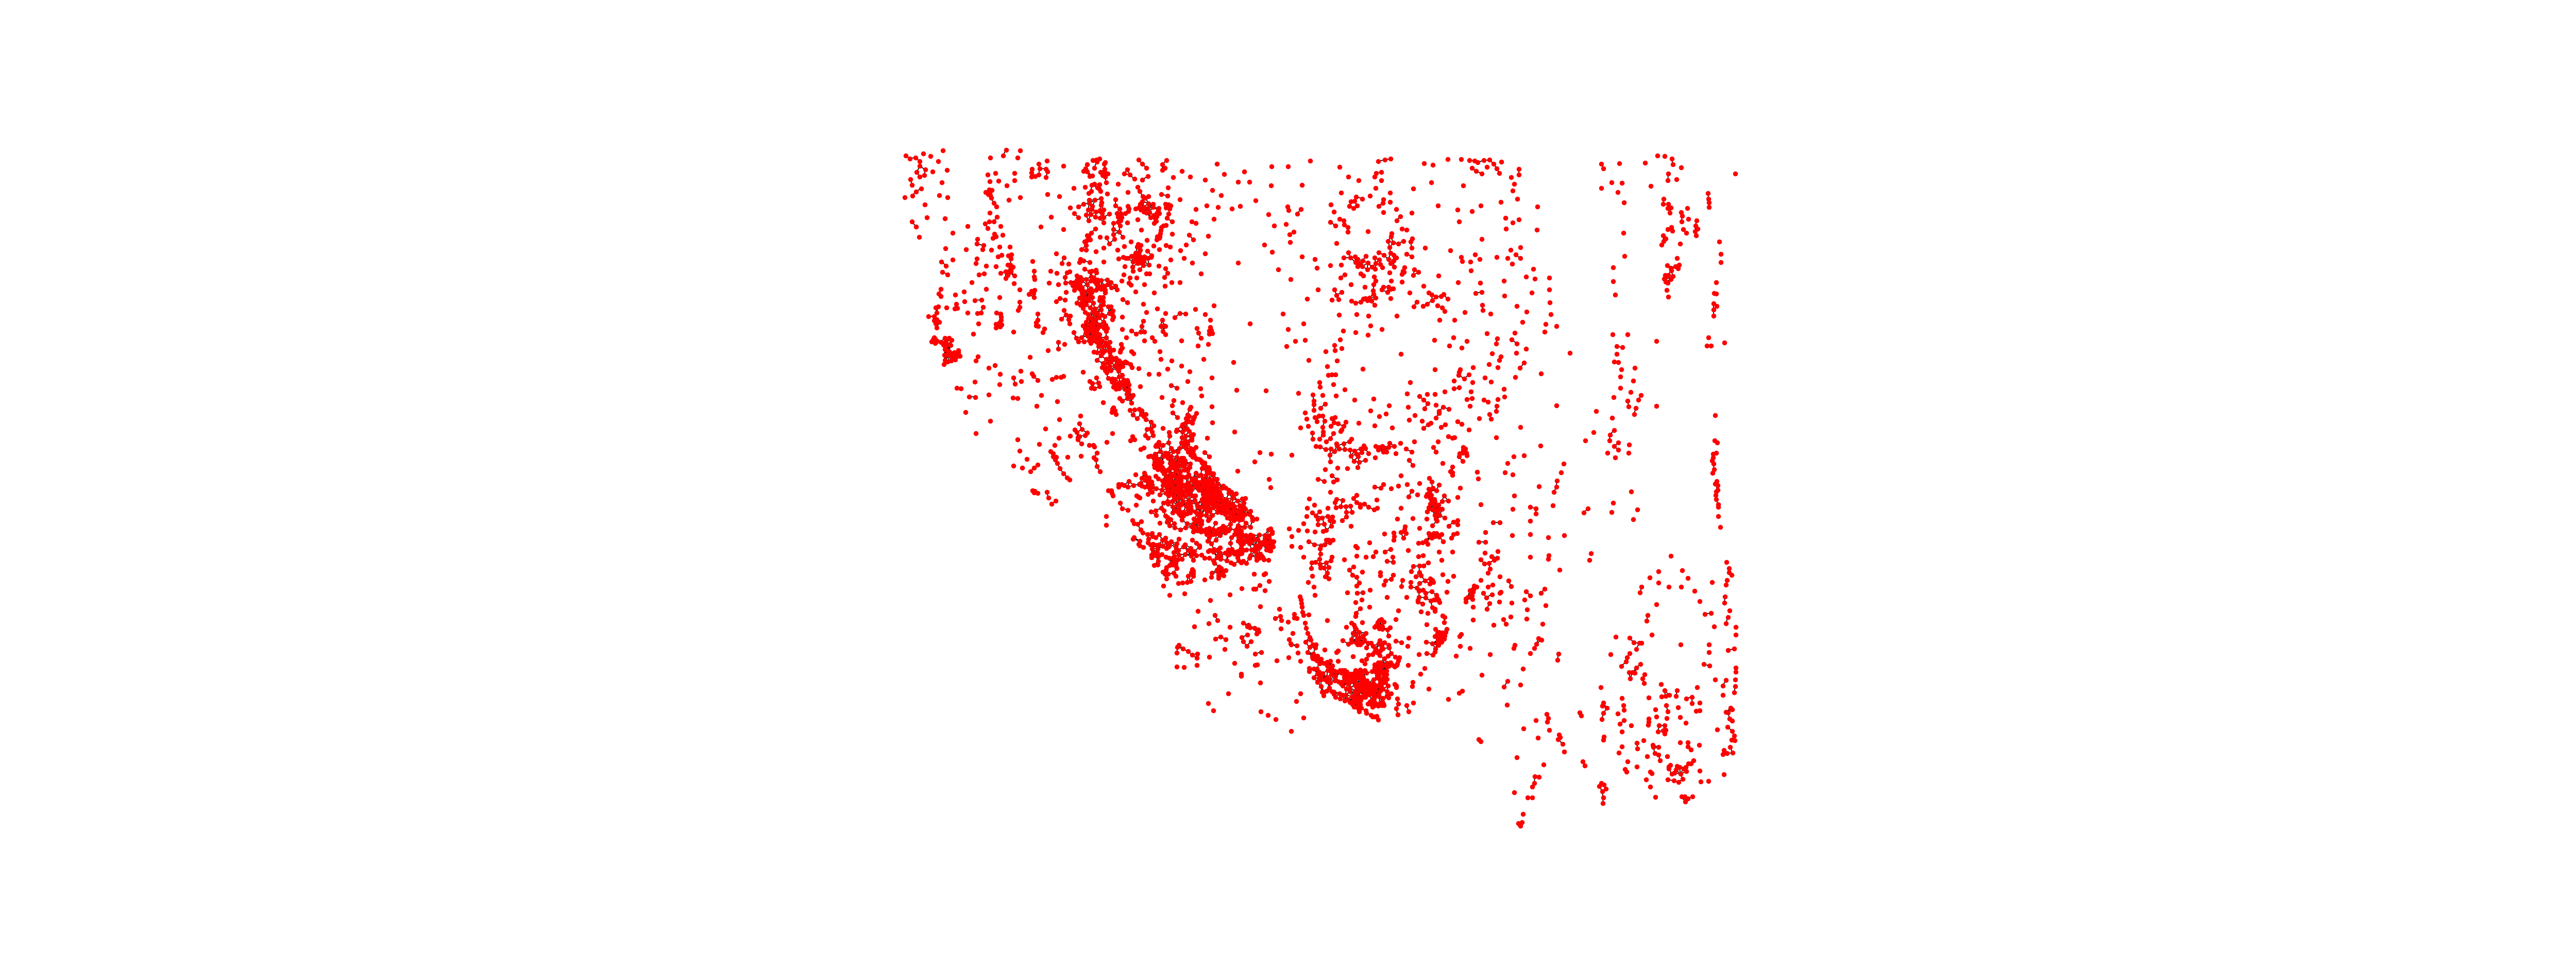

In [12]:
if isGeometricGraph:
    import geometric_graph
    import networkx.drawing as draw

    g, points = geometric_graph.network_from_mask(img_mask, radius)
    nxgraph = misc.igraph_to_nx(g)
    g.vs['pos'] = points.tolist()

    fig = plt.figure(figsize=(40,15))
    ax = plt.subplot(111, aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')
    
    draw.draw_networkx(nxgraph, points, node_size=20, with_labels=False, edge_alpha=0.)

    nxgraph = misc.igraph_to_nx(g)
    nx.write_gml(nxgraph, result_path + "/grafo_" + str(radius) + "r.gml")
    plt.savefig(result_path + "/grafo_" + str(radius) + "r.png")

<IPython.core.display.Javascript object>


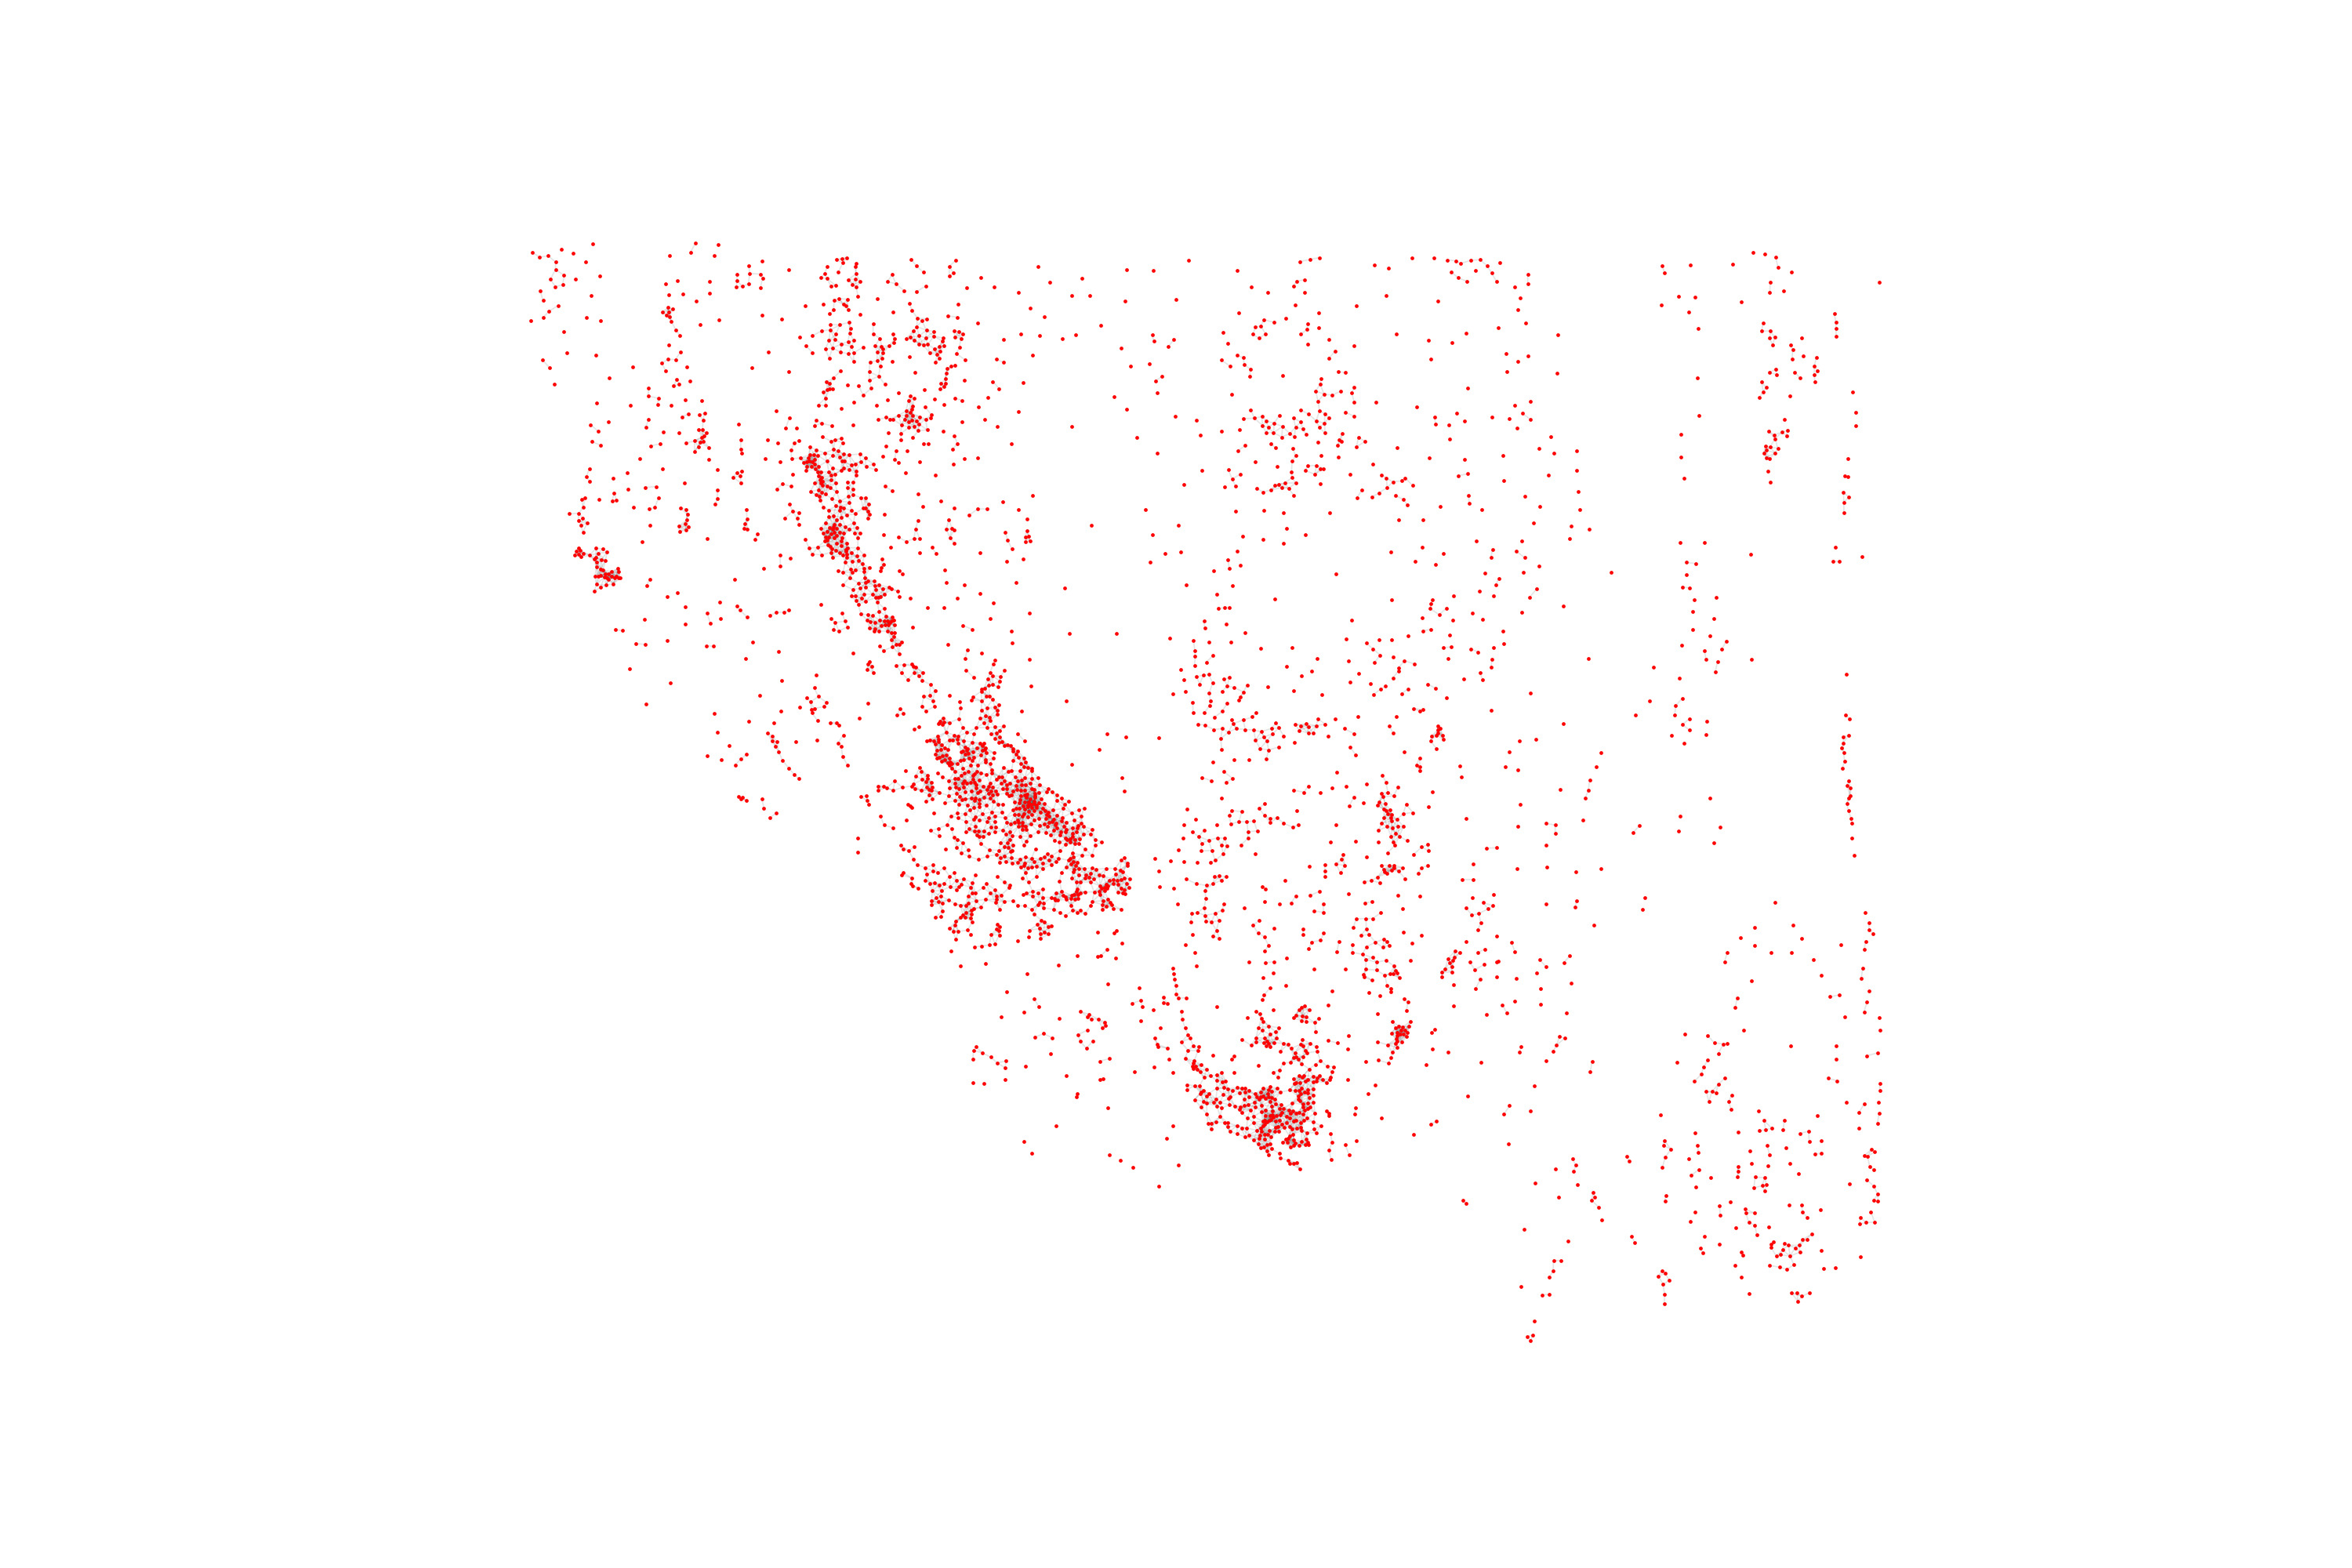

In [13]:
fig = plt.figure(figsize=(24,16))
ax = plt.subplot(111, aspect='equal')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')

draw.draw_networkx_edges(nxgraph, points, alpha = 0.1)
draw.draw_networkx_nodes(nxgraph, points, node_size=3, with_labels=False)
    
#draw.draw_networkx(nxgraph, points, node_size=20, with_labels=False, edge_alpha=9.)

nxgraph = misc.igraph_to_nx(g)
nx.write_gml(nxgraph, result_path + "/grafo_" + str(radius) + "r.gml")
plt.savefig(result_path + "/grafo_" + str(radius) + "r.png", dpi=300)

In [14]:
if not isGeometricGraph:
    # Calculate Voronoi
    g, points, cell_collection = voronoi.voronoi_from_mask(img_mask)
    nxgraph = misc.igraph_to_nx(g)

    nx.write_gml(nxgraph, result_path + "/grafo.gml")

    fig = plt.figure(figsize=(40,15))
    ax = fig.add_subplot(111, aspect='equal', title='Voronoi Network from Image Mask')
    voronoi.plot_data(points, g, cell_collection, ax)

In [15]:
if(len(shape_props[ : , 0 ]) != g.vcount()):
    print('ALERT! PROPERTIES TABLE MUST HAVE THE SAME NUMBER OF GRAPH VERTICES')
else:
    print(str(g.vcount()) + ' Glands')

3364 Glands


<IPython.core.display.Javascript object>


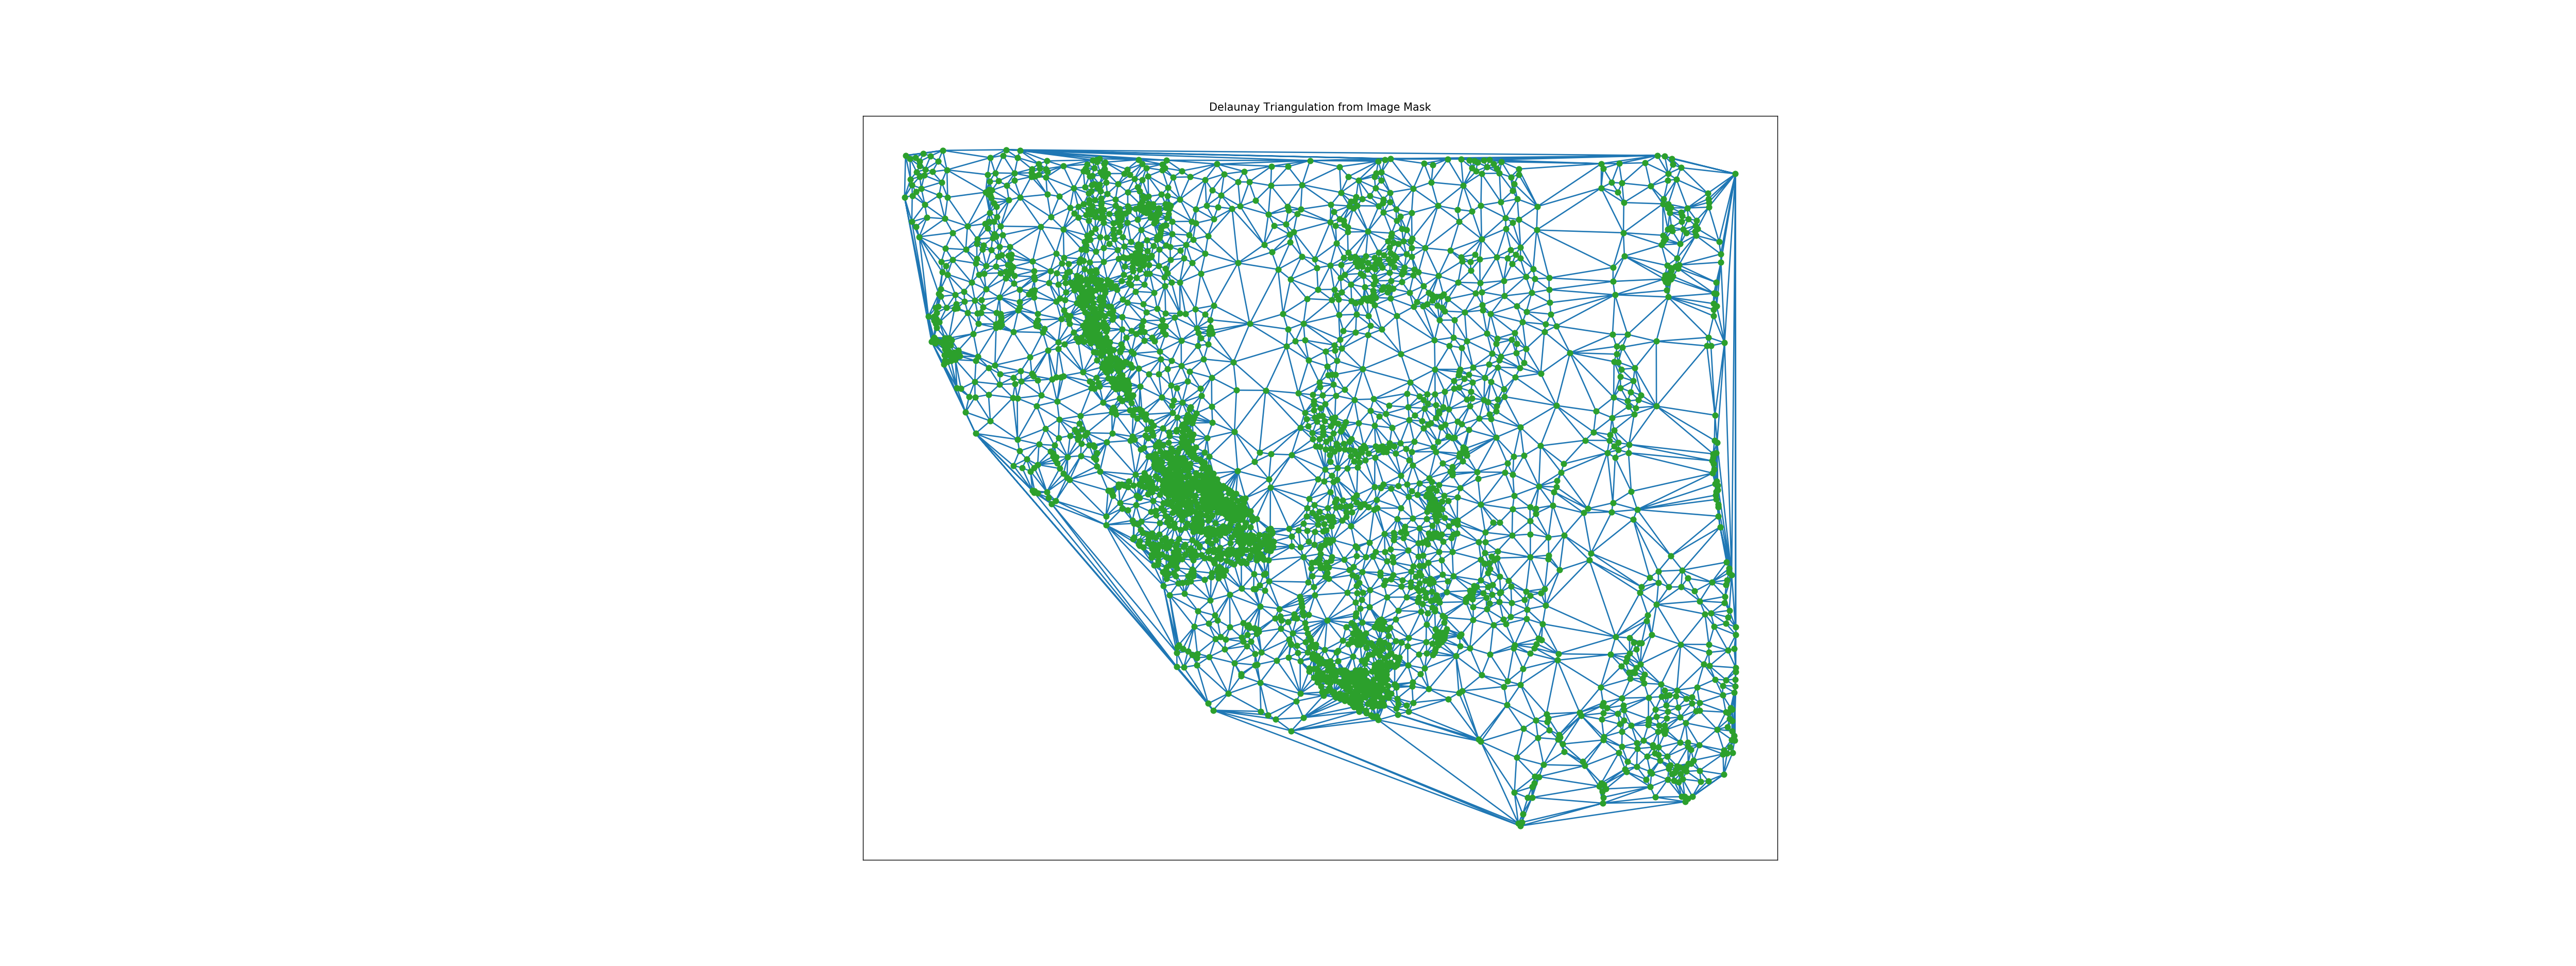

In [16]:
# Calculate Delaunay triangulation. Just for visualization, not used anywhere
tri = Delaunay(points)

fig = plt.figure(figsize=(40,15))
ax = fig.add_subplot(111, aspect='equal', title='Delaunay Triangulation from Image Mask')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

<IPython.core.display.Javascript object>


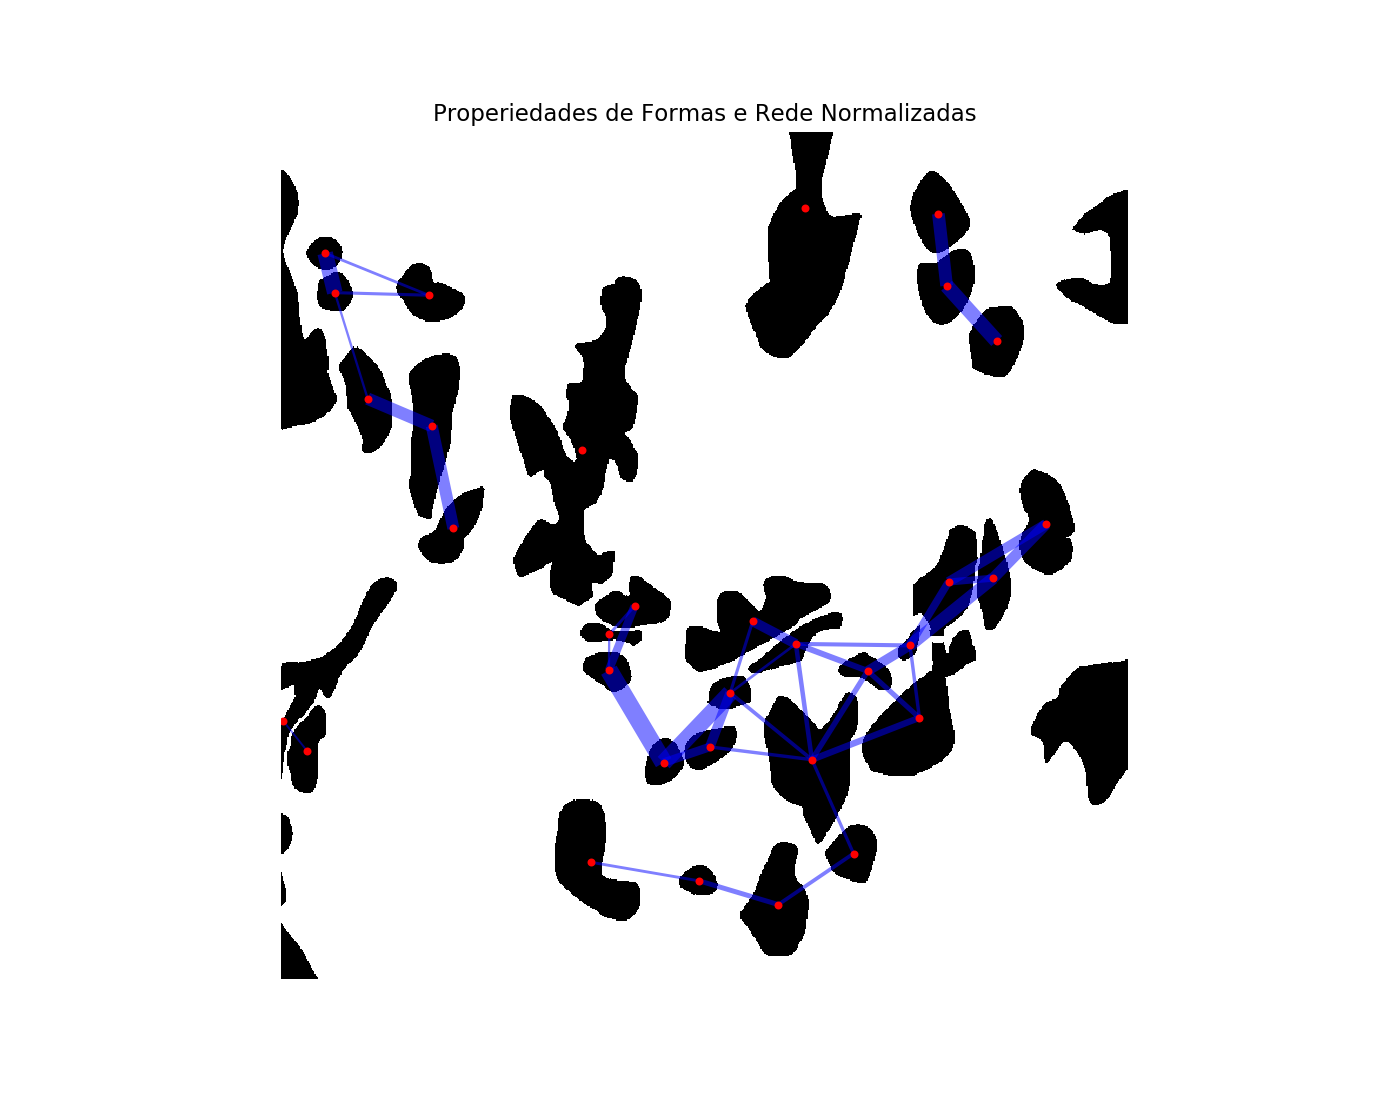

In [23]:
# Calculate edge weights
pos_nodes = g.vs["pos"]
weight_dict = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props, att_idx=None, normalize_pos=True, 
                                        normalize_att=True)
weights = list(weight_dict.values())

file = 'NormalizedProperties_All.png'

misc.plot_graph(nxgraph, pos_nodes, weights, img_mask-255, 
               title='Properiedades de Formas e Rede Normalizadas', path_result = result_path + '\\' + file, 
                min_width=1, max_width=10, alpha=.5, show_edges=True, plt_figsize=(10,8), plt_node_size=10)

In [22]:
result_path + '\\' + file

'prostate_marked/S07_46186 10X_20151028_59/results_radius_100\\NormalizedProperties_All.png'

# Plot results to analyse

<IPython.core.display.Javascript object>


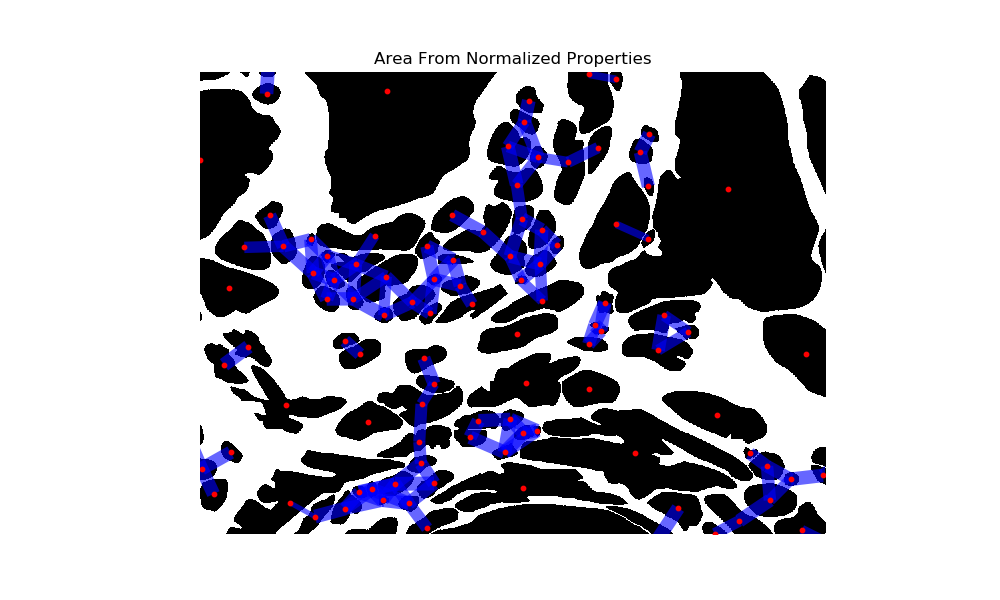

<IPython.core.display.Javascript object>


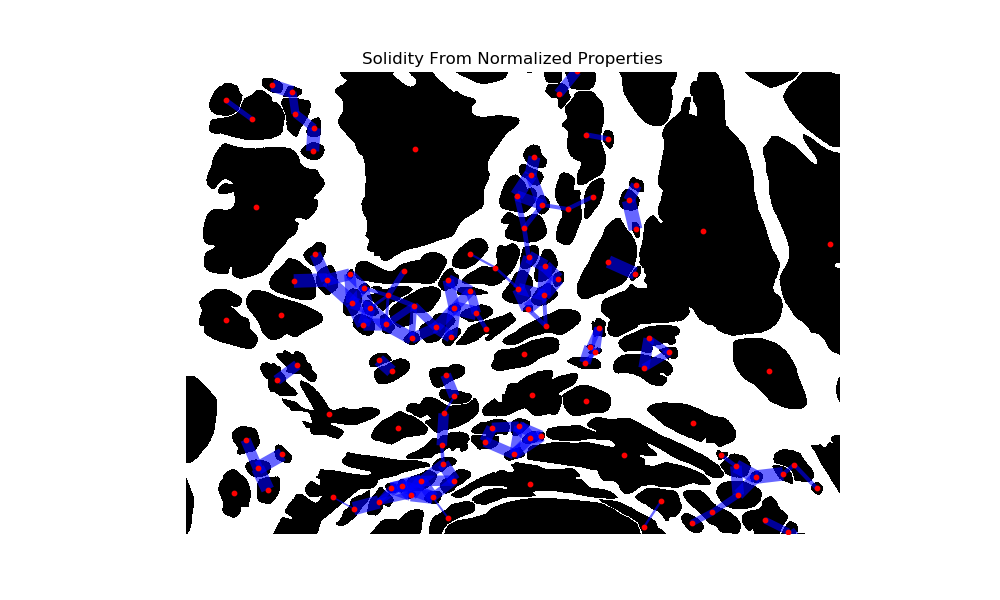

<IPython.core.display.Javascript object>


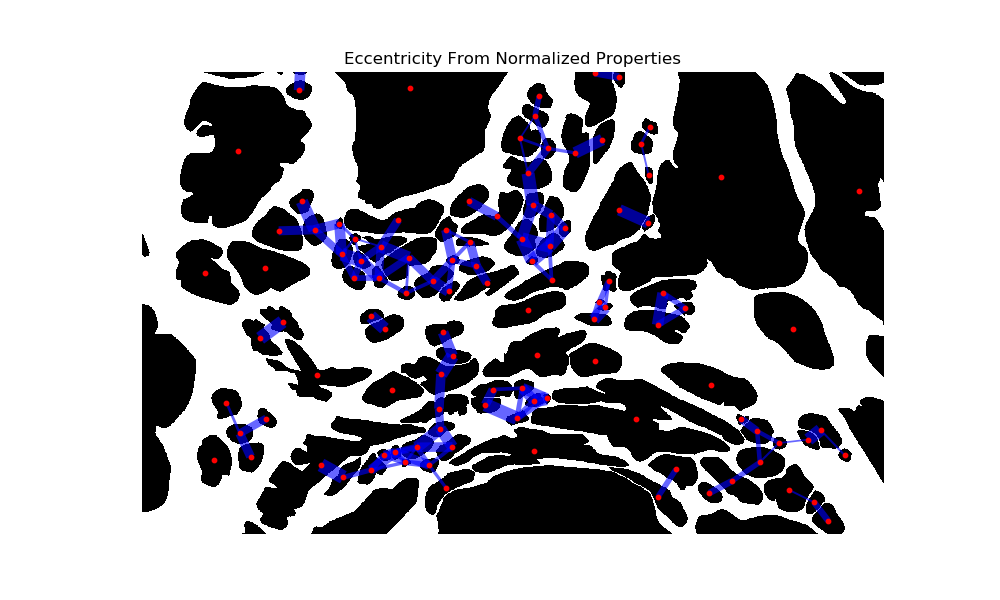

<IPython.core.display.Javascript object>


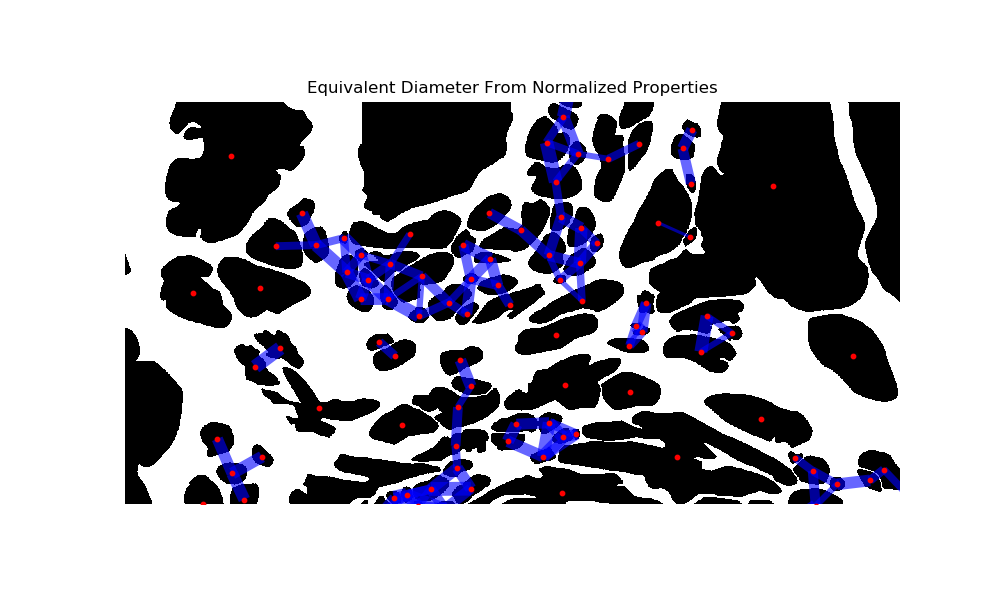

<IPython.core.display.Javascript object>


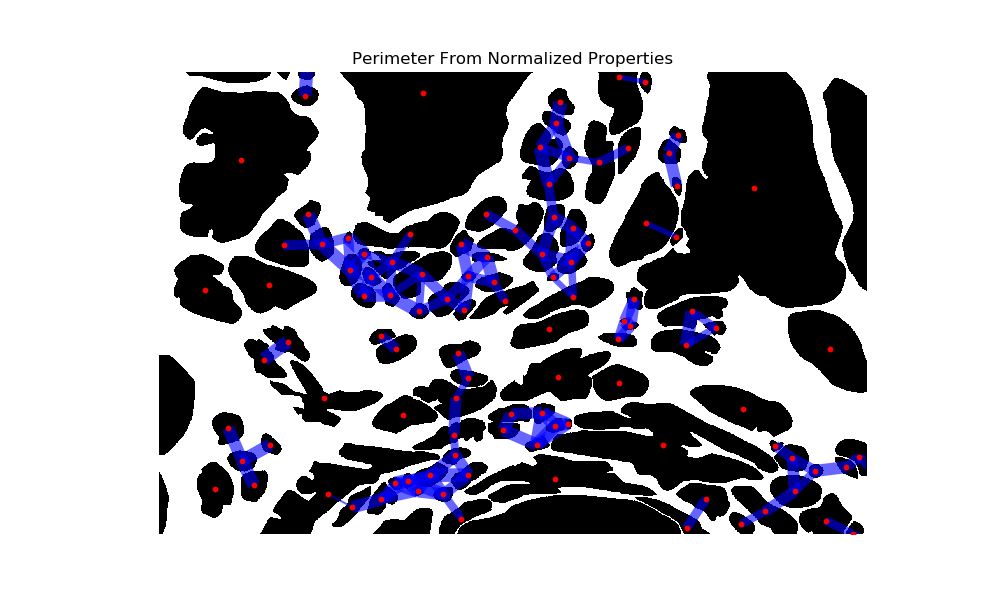

In [48]:
titles_and_files = [['Area From Normalized Properties', 'NormalizedProperties_Area.png'], 
                    ['Solidity From Normalized Properties', 'NormalizedProperties_Solidity.png'],
                    ['Eccentricity From Normalized Properties', 'NormalizedProperties_Eccentricity.png'],
                    ['Equivalent Diameter From Normalized Properties', 'NormalizedProperties_EquivalentDiameter.png'],
                    ['Perimeter From Normalized Properties', 'NormalizedProperties_Perimeter.png']]

for idx, (title, file) in enumerate(titles_and_files):
    weight_dict = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props, att_idx=idx, normalize_pos=True, 
                                            normalize_att=True)
    weights = list(weight_dict.values())
    misc.plot_graph(nxgraph, pos_nodes, weights, img_mask-255, minEdgeWidth, maxEdgeWidth, 
                    title, result_path + '\\' + file, plt_figsize=(10,6))


idx0


<IPython.core.display.Javascript object>


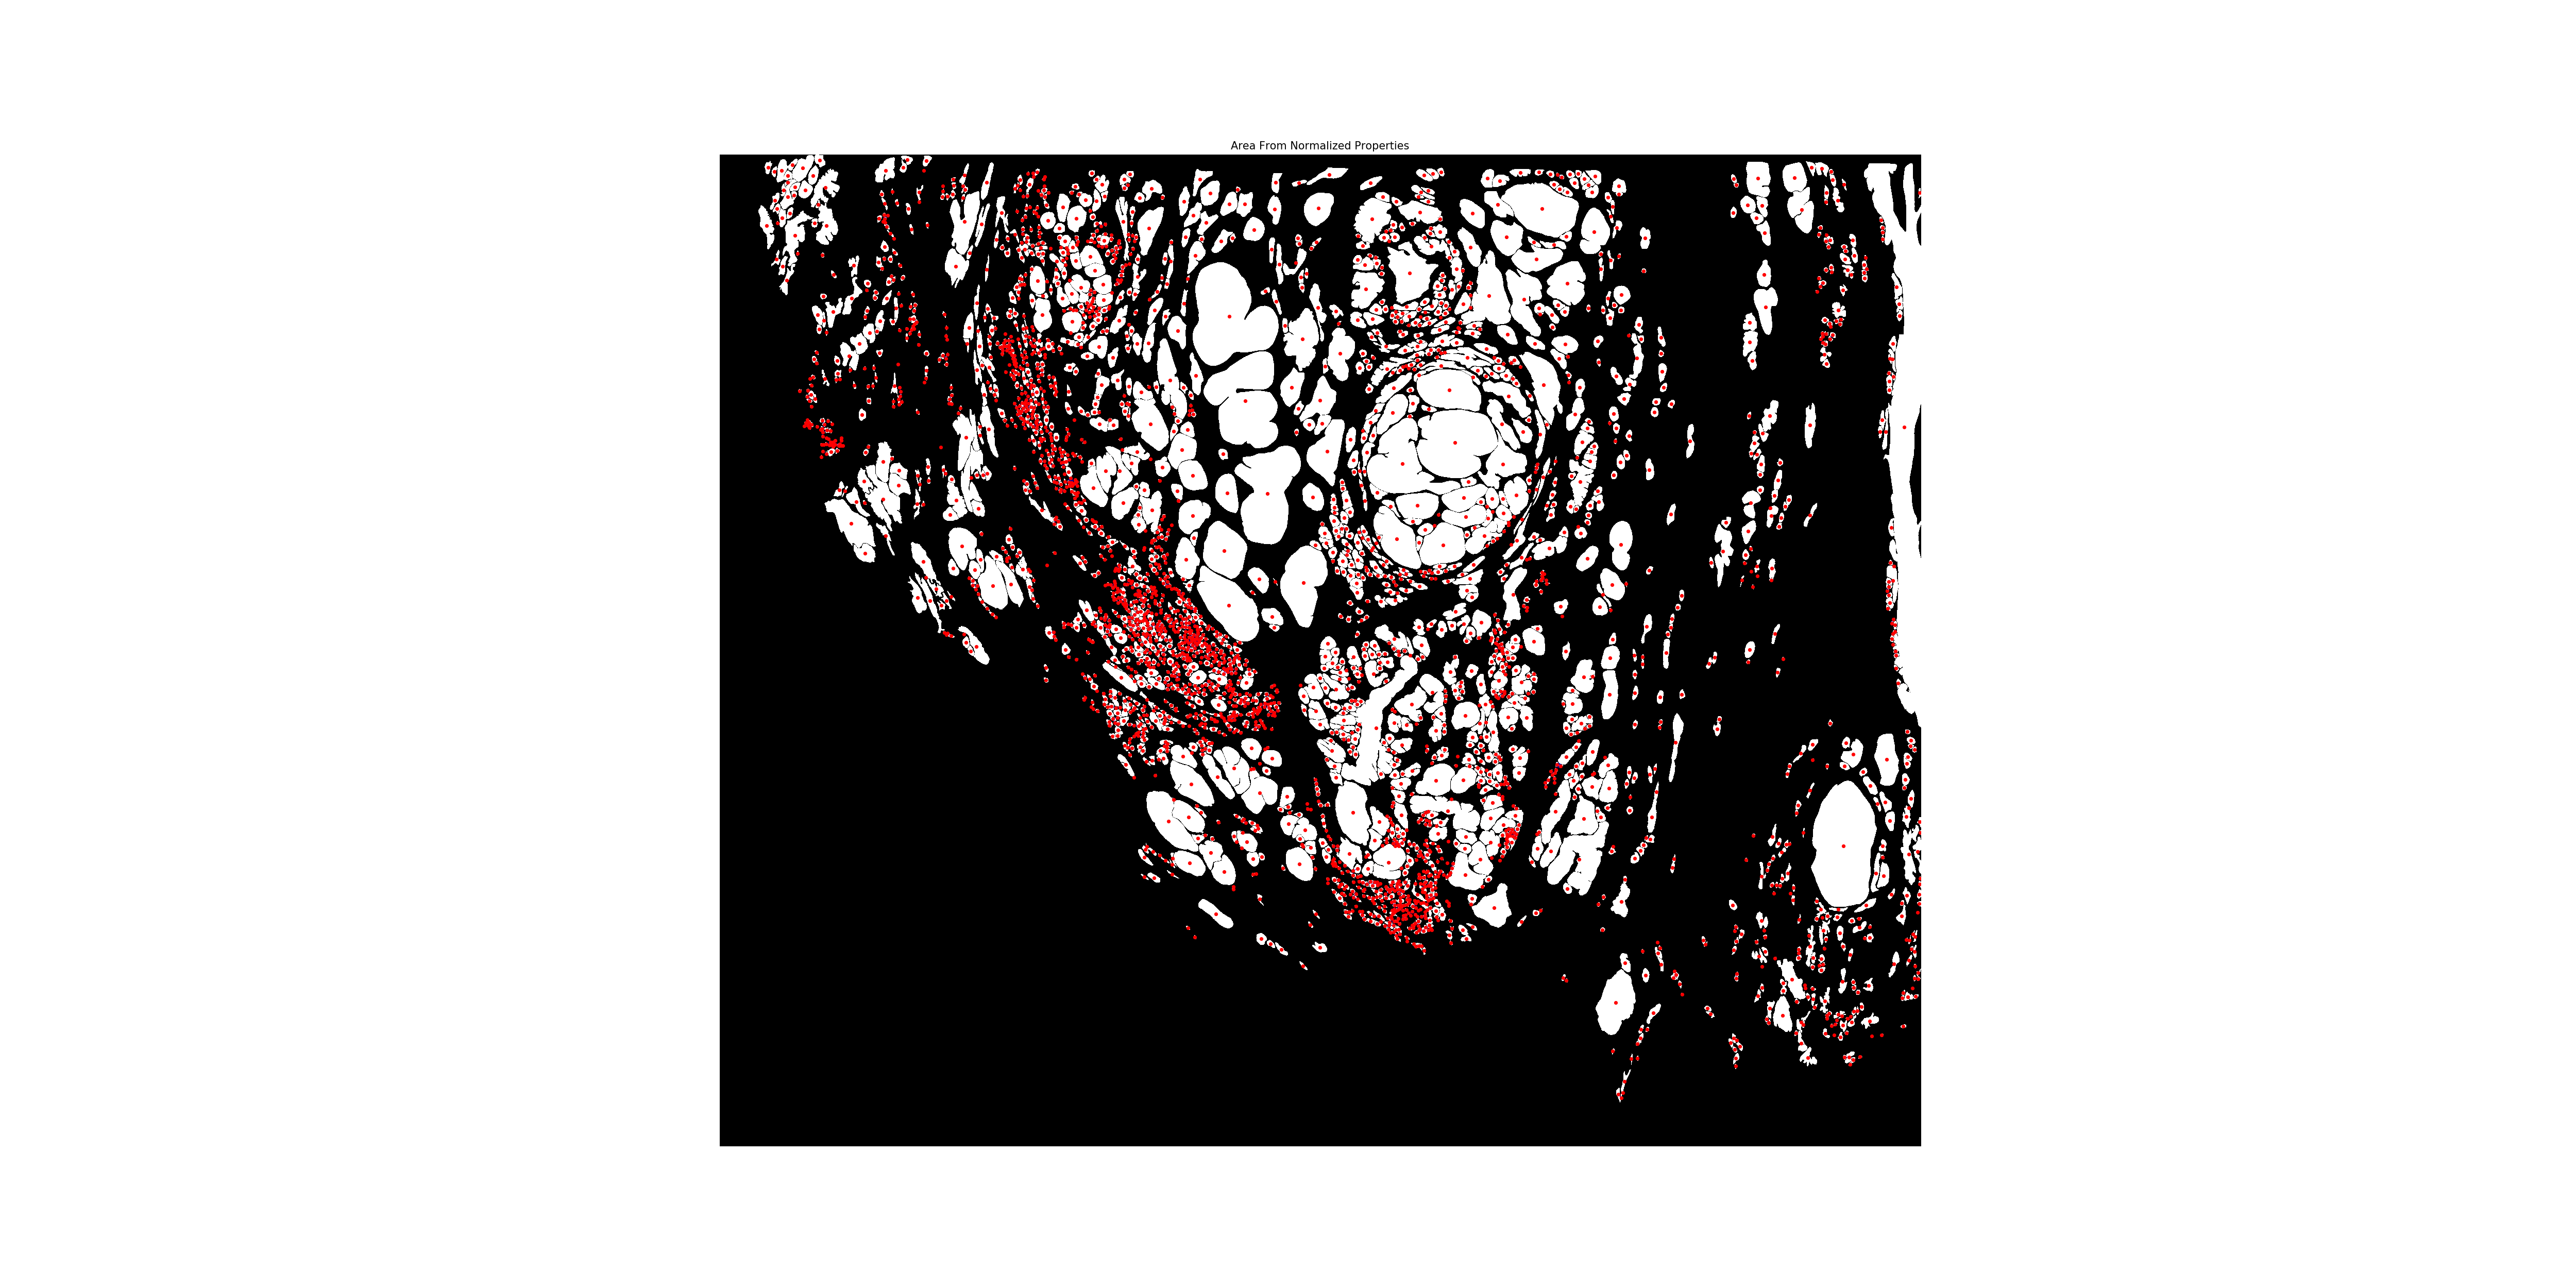

In [65]:
titles_and_files = [['Area From Normalized Properties', 'NormalizedProperties_Area.png']]

for idx, (title, file) in enumerate(titles_and_files):
    print('idx' + str(idx))
    weight_dict = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props, att_idx=idx, normalize_pos=False, 
                                            normalize_att=False)
    weights = list(weight_dict.values())
    misc.plot_graph(nxgraph, pos_nodes, weights, img_mask, 1, 5, 
                    title, result_path + '\\' + file, plt_figsize=(10,6), plt_node_size=10)


In [159]:
att_nodes=shape_props
alpha=1.
att_idx=0
normalize_pos=True
normalize_att=True
pos_means=None
pos_stds=None
att_means=None
att_stds=None

pos_nodes = np.array(pos_nodes)
att_nodes = np.array(att_nodes)
if normalize_pos or pos_means is not None:
    pos_nodes = prop.normalize_values(pos_nodes, pos_means, pos_stds)
if normalize_att or att_means is not None:
    att_nodes = prop.normalize_values(att_nodes, att_means, att_stds)
if att_idx is None:
    # Use all attributes
    att_idx = ...

weight_dict = {}
for edge in nxgraph.edges:
    node1 = edge[0]
    node2 = edge[1]
    pos_node1 = pos_nodes[node1]
    pos_node2 = pos_nodes[node2]
    att_node1 = att_nodes[node1, att_idx]
    att_node2 = att_nodes[node2, att_idx]

    weight = prop.calculate_weight(pos_node1, pos_node2, att_node1, att_node2, alpha)
    print(weight)
    weight_dict[edge] = weight



0.9598575402995871
0.9499935151283603
0.9626367224183764
0.9559313415739324
0.9531599124411844
0.9496729333367362
0.944398379933815
0.9723045254708744
0.9488976453424076
0.9672924079367465
0.9705055823851199
0.9620606108422757
0.9629722184865217
0.9551740221524789
0.952421160783782
0.9700077975267865
0.9663222362972376
0.9660800037348467
0.9844013667213002
0.9634703084697919
0.9594385791563093
0.9759975069372058
0.9635750962856716
0.9539892347386077
0.956971803373328
0.95680122707384
0.9699133325761722
0.9679371504381874
0.9538944214945582
0.9588070752952009
0.9450382833092791
0.9717784340417059
0.9687565720629554
0.9584951597526388
0.966410645644662
0.9540101617512995
0.973886445473636
0.9574603793551251
0.9529058456709267
0.9682407818439356
0.9523748218019793
0.9693805576900479
0.9598197413014663
0.9769909548390325
0.9813068339171664
0.9536736628544763
0.9614638466055281
0.9847732464021688
0.9494474897572824
0.952020181532597
0.9527835716554749
0.9819686765304823
0.9555943627940705
0

0.9533716964377107
0.968003597148853
0.9546095474787556
0.960120434400057
0.968483898390319
0.9466257336883735
0.9520840973762826
0.9561096899609589
0.9620644922994915
0.952131070081295
0.9410396615733053
0.9722370171506364
0.9640263894888302
0.9720763811006723
0.953543617613403
0.9504015367070011
0.9838089892793789
0.987947872400341
0.9729408272226756
0.9515735498889322
0.9629126514073042
0.9653710850639602
0.9810520033392519
0.952768754609852
0.9532510408065121
0.9912491643136982
0.9745237562952794
0.9555953820832606
0.9741934870014138
0.9670827677711127
0.963750044865491
0.9492032642761818
0.94493043223313
0.9651592923090743
0.9737253942501015
0.9706695155713215
0.9624129142370877
0.9914311864486695
0.9836911240750381
0.9869284688387742
0.972374406263072
0.9574672542814462
0.9523618178364007
0.9815393228906676
0.9756520543221932
0.9429002057766335
0.9596863366426026
0.98314867881965
0.9732373623119477
0.9773112131593354
0.9497542484050804
0.9917321246867021
0.9896928272379807
0.9681

0.9553993901709666
0.9723338877567234
0.987730613854914
0.9672899225628504
0.9625185080067606
0.9655160340261373
0.9786123273205916
0.9479355958844439
0.9483638325251587
0.9611663429328229
0.9802210167007133
0.9874179851389879
0.9444827450786412
0.9565165846882437
0.9667537249299761
0.9540076998217355
0.9836702796119655
0.9716985567100835
0.9639362650487073
0.9582479687488501
0.9716571343070332
0.9431391829777208
0.9609787751139276
0.9505935699048403
0.9513998864516318
0.9476558594800842
0.9708880409013211
0.9693557497191051
0.9782899543020857
0.9448286587037584
0.9590588618991872
0.9603006740901826
0.9760737509354375
0.9790496109077258
0.9448044709270556
0.9774924549010472
0.9657687298692478
0.9762410387023566
0.9626041913598452
0.9424157785825836
0.9759495785799673
0.9841039659073347
0.9864357124047727
0.9668431044266318
0.9490916759002567
0.96727621065876
0.9648443069986241
0.9568260149843997
0.9846727199660625
0.9442492345887541
0.9780224761346394
0.9546968850901506
0.9478976454129

0.9576308728435736
0.9752316254242877
0.9553229713368266
0.9790508382758903
0.9581091486281997
0.9515714662637863
0.9652712005197466
0.9478841835615325
0.9579330457778146
0.9731549478709048
0.9589684146080126
0.9840619949887206
0.9730053899704546
0.9548597220709628
0.9614814356769283
0.9735744857531744
0.9425348713354524
0.95084754697125
0.9750764916544792
0.9904832883270605
0.9823753906533785
0.9493379018545919
0.9450909684165882
0.9860575799301571
0.9725041241772925
0.9543212204701982
0.941485856140121
0.9642188831710193
0.9662857116893904
0.9534203158875821
0.9527953639574661
0.9631557499193665
0.9624704184566513
0.9790308400416947
0.9658341110789193
0.9830649339442392
0.965028151302456
0.9854287886859616
0.9754702925830889
0.960964063373958
0.9656979674507423
0.950876275232356
0.9796090851622599
0.9791214178193647
0.9491948563927182
0.9406142923274886
0.9568189944433766
0.9829453757167158
0.9734303795794955
0.9481796715018754
0.9768227773133265
0.9523035807148661
0.9628768826996975

0.957913641308231
0.9496181056994698
0.9752820210186393
0.9649929393142642
0.9525952074687112
0.9823604904209282
0.9441808568234524
0.9649064971815744
0.958034902674972
0.9543355775150197
0.9779374047797567
0.9585767716699398
0.9520242835911512
0.9614405011918588
0.9615762204575363
0.9517310060833944
0.9794932418814796
0.9521717448928889
0.9660041809366035
0.9622618271703498
0.9773380660211067
0.9565181719719432
0.9716091909222058
0.9769301234258908
0.96797383333914
0.9710177526502678
0.9497107082160905
0.9735081145436559
0.9502726089741416
0.9486607925012903
0.9658696373742448
0.9463058153120895
0.965866398075479
0.9763881877069226
0.9424873672584787
0.9469388298215994
0.9591850064055123
0.9527657843061922
0.9748024029814006
0.9407000478996009
0.9735629219173113
0.9528028654408522
0.9631383599144202
0.971352160251078
0.9439275302195606
0.9600901427607692
0.9582049486683968
0.9766335207943534
0.9724725191617475
0.9419682822588366
0.9800415534650994
0.9535876822355663
0.9435220309270835

0.9499241688857878
0.977453304103376
0.948301995786544
0.9763662860884208
0.9504791046197192
0.9446685549280512
0.9524522533633741
0.9483208831520795
0.9614281477790828
0.97492126630731
0.9655885562567433
0.9715607023608124
0.9568388637233396
0.9661616086514235
0.9528088906543939
0.9709681808181359
0.9454055006870903
0.9762651942425642
0.9862197045181424
0.948103951037408
0.9833612973021095
0.9699521710046023
0.9436282490010085
0.941752564337556
0.9483098599964428
0.9464503584514699
0.9922320182211343
0.9623237289741988
0.944527175026633
0.9436712817650112
0.945763431317169
0.9653439407526011
0.9482360450341892
0.9772798793281892
0.9724291919534259
0.9580750880128912
0.953852031560413
0.9560759066077187
0.9586728377999526
0.981763621832124
0.9544318846106414
0.9579347234757347
0.9734055537757977
0.9522228199203675
0.9479338947939416
0.9718737434328878
0.9438128472075367
0.9439921785420116
0.950511326923417
0.9871989301646392
0.953846444681143
0.9483855761619067
0.9477288044530137
0.957

0.9566668190147228
0.956902880406161
0.951130704750657
0.9825697224650264
0.9425171036924853
0.9597702963807142
0.9684219038764942
0.940774774009861
0.9464958699425821
0.9617395270161968
0.9439481246546163
0.9752046397167575
0.9790642943062927
0.9554593547699924
0.9887461871110588
0.9514334767228207
0.9499100890720374
0.9710250854853815
0.9631088475657713
0.9672917436799507
0.9433339624930306
0.9747311719392481
0.9573143254648792
0.9768091108412147
0.9544751790622683
0.955416085820218
0.9544665746695707
0.9661883061595156
0.9644257786182941
0.9557773720668994
0.9679108137545476
0.9657246508721545
0.9481965004255035
0.9571748028288148
0.9878467722816158
0.9505073770455265
0.9594551477051416
0.9522598251575495
0.9876977730130506
0.955494987169314
0.9747776968406218
0.9738251220697296
0.9525135617546883
0.9508592068506497
0.9424352168099316
0.9797131462139597
0.9552427261988901
0.9834994899653214
0.98763698290959
0.9669980373389164
0.9464111370498965
0.9584017142767882
0.9526159923208979


0.9461270103240677
0.9683404576606326
0.9802323829752152
0.9583207875702053
0.9675142939922342
0.9655647230352262
0.9487122481983329
0.9590380390802089
0.9765368172626037
0.9455481682194508
0.9844952016416838
0.9650374826400903
0.9529311997625113
0.9417121879702849
0.9902550201451668
0.9845862179301713
0.9519427302427389
0.977607422267617
0.9638449775231854
0.9931197899229387
0.9708300985902198
0.9709738305929724
0.960930256744207
0.9761609161776026
0.9617261487224394
0.9832802516207759
0.9565001005732611
0.9553615601839436
0.9499189502822886
0.9721564687047811
0.9422183281542221
0.9722256205454805
0.9543022031244534
0.9826265492746592
0.9517384823759513
0.9529448943120808
0.9833406640685579
0.9660993994261151
0.9769988461995479
0.9454338602109856
0.9598342057007662
0.9543919415678228
0.979373404948283
0.948605034542489
0.9561053932518286
0.9607636214375693
0.9665716217883938
0.9676268609821508
0.9711997192835498
0.9545896178277868
0.9915683665835122
0.9520242994528978
0.98229549041004

0.964950359124161
0.9664542374217918
0.9858342705368521
0.9678250190177055
0.9499204219609252
0.9497413845601009
0.9791651157220232
0.9686413919647973
0.9676737068251955
0.9458009453964995
0.9472727764248735
0.9637962066573168
0.9651946397859674
0.9818798738404496
0.9612529047991009
0.9617440633504044
0.9590155160749175
0.964716150408653
0.9861076110207354
0.9558646915702462
0.9623927718378994
0.967749473620187
0.9849397671588169
0.9697311273564941
0.960186374860465
0.972982638029337
0.9561271359966892
0.981398573140748
0.9537039707935011
0.9578190605728479
0.9725994810186505
0.9659270160284962
0.9923640795344897
0.9695401419670566
0.9525222499981412
0.9735342223436393
0.9627668530783802
0.9576672529978154
0.980748300607959
0.9410363567253829
0.9755563952938832
0.9827342611306893
0.9784675294843294
0.965496934008303
0.9555512053954853
0.9887044494011812
0.9535054274184476
0.9505100038062555
0.9551159001331394
0.9636262539865159
0.950904126315653
0.9551624149642438
0.9599594937055563
0.

0.9449612748846448
0.9606431808995816
0.9679357985408935
0.9723562756286437
0.9692232017539352
0.9495461223918087
0.9541409521643065
0.9630699722696117
0.965826560817834
0.9846289793197126
0.9562650167476264
0.9628411159548078
0.9460882469369005
0.9767600998027564
0.9623788405729798
0.9712162564038118
0.981542546928309
0.9629412019729541
0.957868495719192
0.9568403787915201
0.9499766335848204
0.97728853050566
0.9623210310490173
0.952814146389051
0.9533837747411594
0.9627256073695559
0.9831539210915418
0.9541350961492624
0.9762177724992286
0.9831575454026197
0.9724080795186536
0.9551801776163621
0.9540128662857452
0.961560460433946
0.983054466967671
0.9509646991022046
0.9710999614092499
0.9699326724968108
0.9468925876081611
0.9431032954308559
0.9492653626984339
0.9801863541985624
0.9632132578390545
0.9825870142284672
0.9506364973908642
0.9649859400642316
0.968699703493234
0.9527860854610511
0.9643140712497509
0.9792856113906803
0.9444213551289032
0.9677917247529244
0.9735272822324441
0.

0.9845085013148075
0.9765083188865364
0.9572286696487571
0.9606171241041385
0.9507757083593609
0.9504781431431997
0.9661082049448652
0.9598174934179085
0.9589850959797686
0.976936844308514
0.9601003388686771
0.9547129905956894
0.9808046193288867
0.9665481731354433
0.9648554398140322
0.9860211123941968
0.9610454800138067
0.9659683305244048
0.9829515820735354
0.9612157320446736
0.9783372391064858
0.9530912208949811
0.9810581568431435
0.967848522093804
0.9481390614925219
0.9458447201338399
0.9736081455135075
0.9895479252930216
0.9722108962357868
0.9574244940865508
0.9445020716199879
0.9432810306356598
0.9555365087583436
0.9760522039731151
0.9713776113009743
0.9715913961730517
0.9770218786087135
0.9659368729491784
0.950065810593251
0.9787305423099788
0.9457750809982355
0.9582050736025834
0.9890620176545345
0.9856947621014674
0.9704303217463415
0.9483453564146974
0.9725987232447977
0.974790574039653
0.9718678089952089
0.9623937263587887
0.9568271712693178
0.9893114033614179
0.98079691078373

0.9873888213203887
0.9510876017320969
0.9489978435132529
0.9412156648339086
0.9582810608408723
0.9502276840112517
0.9649226930409128
0.9574196693910991
0.9613752975688903
0.9566421761087621
0.9754876199495761
0.988664930404213
0.9789153634864154
0.9440717843166675
0.9416688080415325
0.9537315741367286
0.9744033107577782
0.967855074292232
0.9555646194895927
0.955728463599173
0.9689605344342808
0.9713494434699346
0.9562424107060858
0.950665957127303
0.9666176524460139
0.9504888269101139
0.9454629273760584
0.9608184729931459
0.9533220180490447
0.9677438627046951
0.9863208802989935
0.944999299126333
0.9516484316977943
0.9597935194190412
0.97975475312982
0.9757178025036453
0.9664528019472037
0.9654107957175428
0.9685067764713012
0.9568582113529627
0.9721010690359595
0.972236729808967
0.9673538723466756
0.9557004205471183
0.9831473064521615
0.948194296041959
0.9826248317416605
0.9483139609141845
0.9709589534004649
0.9908164786477108
0.9630468743040682
0.9841722407327423
0.949939137007555
0.9

0.958644598134217
0.9711872497880143
0.9621633763227133
0.942050228517006
0.9557105631318514
0.9472323257428287
0.976969415740113
0.9795215490678695
0.9716459137808363
0.9585631097107212
0.959801224956436
0.9764952157663315
0.964493598601002
0.9438951511806171
0.9554243760369199
0.9491491018206722
0.9574101801643119
0.9657404658542009
0.9768380856906415
0.9835027924465595
0.9704914450857303
0.9614113195572949
0.9459441221964979
0.9538388185851969
0.960170670488914
0.9669703968009992
0.9532528155892372
0.9622964582123558
0.9687877102976792
0.9734360484829881
0.9549180449058264
0.9597793816267512
0.940402353741531
0.9523003963968424
0.9481751603763973
0.9692895091456557
0.9569780045211763
0.9408690881065453
0.9784718874008688
0.957913018227009
0.9798387080182551
0.9814142345601916
0.9616018051448261
0.9747117597203921
0.968173392348747
0.9415762878923231
0.986498962930927
0.9541675306895788
0.9783438555396188
0.9563305256991029
0.9420023747575546
0.9609706948818375
0.9476142819973427
0.9

0.9641531160056381
0.9658984876721711
0.9486598096344936
0.9704842423349582
0.9612363593353113
0.978560020325925
0.986107404204377
0.9505330260793584
0.9875211571841186
0.9579234727733057
0.9660952605115329
0.9423256572025341
0.9473047184715663
0.9436213640332509
0.9782900211760621
0.9877256559692256
0.9412352614331312
0.9738175028843264
0.9489384576242375
0.9418818857485244
0.9507160628379885
0.943113255860191
0.961002190669
0.9776727053409101
0.9597778467275797
0.9562777547354399
0.9540878426061804
0.9787092702205932
0.9433208199950426
0.9673862588620944
0.9437521786875854
0.9660807444806332
0.9663427949540039
0.9487483965041473
0.944570879505067
0.9673085970470092
0.9558332482871491
0.9514844123921057
0.9602538140375338
0.9485475082828009
0.9743125240500273
0.9881936594705297
0.9593190117073872
0.9621751107236055
0.9832260135292894
0.9524517233851277
0.965206751697018
0.9687590354139939
0.9713723453403006
0.9588944536161385
0.9603086291146614
0.9495677644988963
0.9539128407763267
0.

0.9721684314650159
0.9639329479795337
0.9529251485921204
0.9889855386298073
0.9869548801985241
0.9533496014344046
0.9724664644461489
0.9555507808107572
0.964517483383386
0.9867885228213952
0.9443362931734479
0.9640845482852985
0.9724542510593857
0.9500808643161777
0.9408843368284223
0.9495049000555807
0.95797350558889
0.9882910170518514
0.9821953965140605
0.9749209799172239
0.9676638032105618
0.9644416719767805
0.9648065306726746
0.9694336305890974
0.9747392590388927
0.964279165267782
0.9627472332797213
0.9581822017985498
0.9757807135207575
0.9698773797166236
0.9846033528990916
0.9586034084695046
0.9815776041380421
0.9845671638425885
0.9529366580583928
0.960679008999399
0.9622093236474352
0.9883391044845975
0.962414079529452
0.9481180565722893
0.9504511374748125
0.9844016471785176
0.9651902490085782
0.9627250698824227
0.9789601210745787
0.958817678499742
0.9622054450215756
0.9609980755881452
0.9570013205525931
0.949038623904534
0.954316717145513
0.9521376159157058
0.9730353556807867
0.

In [161]:
#list(att_nodes[:,0])
max(list(weight_dict.values()))


0.9947330164724573

<IPython.core.display.Javascript object>


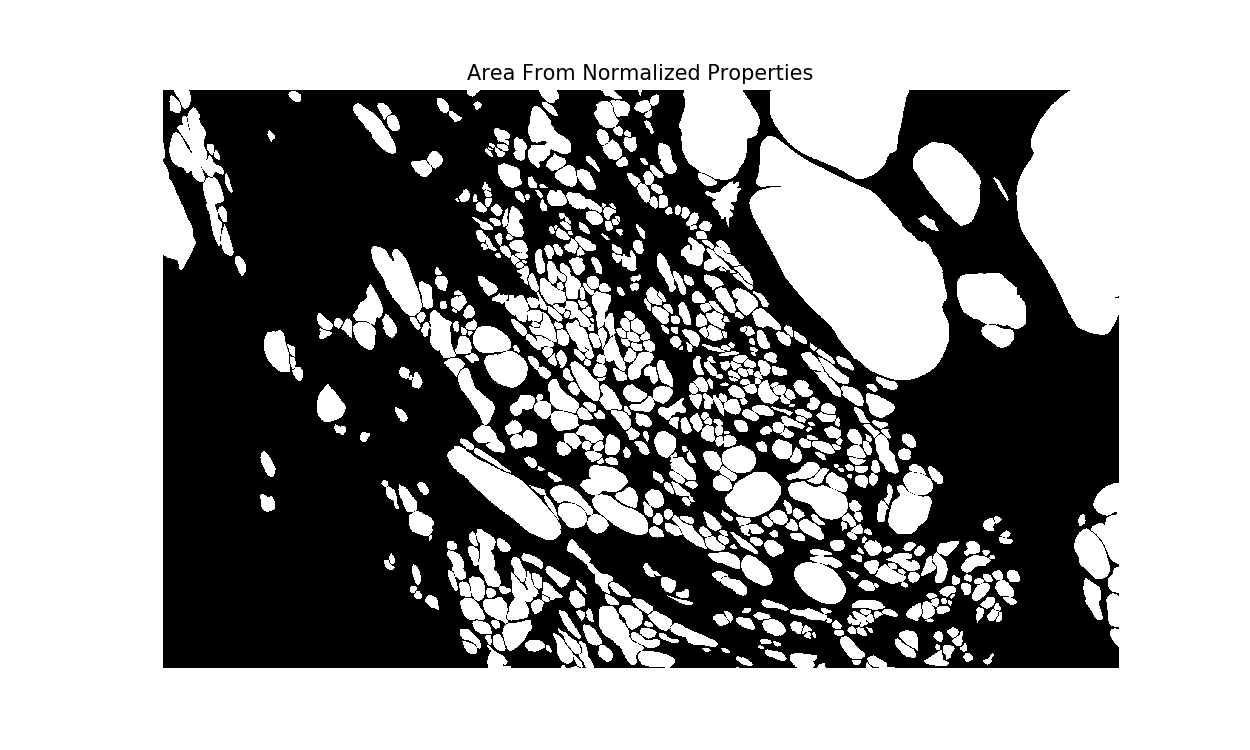

In [163]:
weights = list(weight_dict.values())
misc.plot_graph(nxgraph, pos_nodes, weights, img_mask, 1, 30, 
                title, result_path + '\\' + file, plt_figsize=(10,6), plt_node_size=10)

In [ ]:
titles_and_files = [['Solidity From Normalized Properties', 'NormalizedProperties_Solidity.png']]

for idx, (title, file) in enumerate(titles_and_files):
    weight_dict = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props, att_idx=idx, normalize_pos=True, 
                                            normalize_att=True)
    weights = list(weight_dict.values())
    misc.plot_graph(nxgraph, pos_nodes, weights, img_mask, minEdgeWidth, maxEdgeWidth, 
                    title, result_path + '\\' + file, plt_figsize=(40,20), plt_node_size=20)


In [ ]:
titles_and_files = [['Eccentricity From Normalized Properties', 'NormalizedProperties_Eccentricity.png']]

for idx, (title, file) in enumerate(titles_and_files):
    weight_dict = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props, att_idx=idx, normalize_pos=True, 
                                            normalize_att=True)
    weights = list(weight_dict.values())
    misc.plot_graph(nxgraph, pos_nodes, weights, img_mask, minEdgeWidth, maxEdgeWidth, 
                    title, result_path + '\\' + file, plt_figsize=(40,20), plt_node_size=20)


# Adding Network Properties

In [ ]:
#Network Properties
weight_dict = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props, att_idx=None, normalize_pos=True, 
                                        normalize_att=True)
weight_dict_area = prop.calculate_weight_all(nxgraph, pos_nodes, shape_props_area, att_idx=None, normalize_pos=True, 
                                        normalize_att=True)
nx.set_edge_attributes(nxgraph, weight_dict, 'weight')
nx.set_edge_attributes(nxgraph, weight_dict_area, 'weightarea')
net_props = prop.get_graph_props(nxgraph)

In [ ]:
class gland_property():
    img = None, False, -1, None, None, None, None, None, None, None

    def __init__(self, _id, _row, _column, _area, _demarcated, _solidity, _eccentricity, _equivalent_diameter, _perimeter, _degree, _strength, _betweenness):
        #identification
        self.id = _id,
        self.row = _row,
        self.column = _column,
        self.demarcated = _demarcated
        #shape measures
        self.area = _area, 
        self.solidity = _solidity,
        self.eccentricity = _eccentricity,
        self.equivalent_diameter = _equivalent_diameter,
        self.perimeter = _perimeter,
        
        #net properties
        self.degree = _degree
        self.strength = _strength
        self.betweenness = _betweenness

if isMount:
    gland_properties  = []
    count = 0

    for idx in range(len(shape_props)):
        
        position = list(map(int, props[idx].centroid))
        
        obj = gland_property(_id = count, _row=int(position[0]), _column=int(position[1]), _demarcated=(expert_demarcation[position[0]][position[1]]==255), _area=shape_props[idx][0], _solidity=shape_props[idx][1], _eccentricity=shape_props[idx][2], _equivalent_diameter=shape_props[idx][3], _perimeter=shape_props[idx][4], _degree=net_props[idx][0], _strength=net_props[idx][1], _betweenness=net_props[idx][2])
        gland_properties.append(obj)
        
        count = count + 1

demarcated_quantity_ = [(t.row[0],t.column[0]) for t in gland_properties if t.demarcated == True]
print('Glands in Demarcated Area: ' + str(len(demarcated_quantity_)))        

# Create TXT with glands properties

In [ ]:
with open(result_path + '/glands_properties_' + str(radius) +'r.txt', 'w') as f:
    f.write('idx, row, column, demarcated, area, solidity, eccentricity, equivalent_diameter, perimeter, degree, strength, betweenness\n')
    for item in gland_properties:
        f.write("%d, %d, %d, %s, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f\n" % (item.id[0], item.row[0], item.column[0], item.demarcated, item.area[0], item.solidity[0], item.eccentricity[0], item.equivalent_diameter[0], item.perimeter[0], item.degree, item.strength, item.betweenness))

In [ ]:
nxgraph_properties = nxgraph = nx.Graph(nxgraph)

id_dict = {}
row_dict = {}
column_dict = {}
demarcated_dict ={}
area_dict = {}
solidity_dict = {}
eccentricity_dict = {}
equivalent_diameter_dict = {}
perimeter_dict = {}
degree_dict = {}
strength_dict = {}
betweenness_dict = {}

for t in gland_properties:
    id_dict[t.id[0]] = t.id[0]
    row_dict[t.id[0]] = t.row[0]
    column_dict[t.id[0]] = t.column[0]
    demarcated_dict[t.id[0]] = str(t.demarcated)
    area_dict[t.id[0]] = t.area[0]
    solidity_dict[t.id[0]] = t.solidity[0]
    eccentricity_dict[t.id[0]] = t.eccentricity[0]
    equivalent_diameter_dict[t.id[0]] = t.equivalent_diameter[0]
    perimeter_dict[t.id[0]] = t.perimeter[0]
    degree_dict[t.id[0]] = t.degree
    strength_dict[t.id[0]] = t.strength
    betweenness_dict[t.id[0]] = t.betweenness
    
nx.set_node_attributes(nxgraph, id_dict, 'idx')
nx.set_node_attributes(nxgraph, row_dict, 'row')
nx.set_node_attributes(nxgraph, column_dict, 'column')
nx.set_node_attributes(nxgraph, demarcated_dict, 'demarcated')
nx.set_node_attributes(nxgraph, area_dict, 'area')
nx.set_node_attributes(nxgraph, solidity_dict, 'solidity')
nx.set_node_attributes(nxgraph, eccentricity_dict, 'eccentricity')
nx.set_node_attributes(nxgraph, equivalent_diameter_dict, 'diameter')
nx.set_node_attributes(nxgraph, perimeter_dict, 'perimeter')
nx.set_node_attributes(nxgraph, degree_dict, 'degree')
nx.set_node_attributes(nxgraph, strength_dict, 'strength')
nx.set_node_attributes(nxgraph, betweenness_dict, 'betweenness')

nx.write_gml(nxgraph_properties, result_path + "/grafo_glands_properties_" + str(radius) + "r.gml")

In [ ]:
nxgraph.nodes()[0]

In [ ]:
#access graph properties
nxgraph.nodes[50]['idx']